# Data Mining of Network Measurements
<BR>
<BR>
<center>
A short course at the 5th PhD School on Traffic Monitoring and Analysis
<BR><BR>
Barcelona
<BR><BR>
April 22, 2015
</center>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print ''

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

I'd like to try to divide the world of network measurements into two categories:

1. Measurements that reflect aggregate human activity.
2. Measurements that do not.

In the first category I would place

* network data traffic
    * traffic timeseries
    * source-destination traffic matrices
* social media
    * blogging/microblogging traffic
* mobile location traces
* mobile call traffic
* web browsing traces
* content popularity and user preferences

In the second category I would place

* network topology
    * router level
    * AS level
* network paths 
* protocol traces
    * TCP, OSPF, BGP, IEEE 802

And there are some I am not sure of:

* Spatial/geographic distribution of network elements
* Social network structure
* Attack and <div color='red'>malicious traffic</div> 

## My Claim



__In the aggregate, "normal" human activity is frequently low-dimensional.__


I'll call this the "low-dimensional phenomenon."

In the rest of this lecture I'll answer these two questions:

1. What does "the low-dimensional phenomenon" mean?

2. Why does "the low-dimensional phenomenon" matter?

# What Does the Low-Dimensional Phenomenon Mean?

1. Effective Dimension 
    2. Defining Effective Dimension
    3. Finding Effective Dimension
4. Empirical Evidence
5. Interpretation: 
    2. Common Patterns
    3. Latent Factors

### Effective Dimension

We'll concern ourselves with tabular measurement data in the form of matrices.

Rows, columns, and matrix elements can correspond to a wide variety of things.  Here are some examples.

<table>
<tr><th>Data Type</th><th>Rows</th><th>Columns</th><th>Elements</th></tr>
<tr><td>Network Traffic<td>time bins</td><td>OD flows</td><td>Number of Bytes</td></tr>
<tr><td>Network Traffic<td>Sources</td><td>Destinations</td><td>Number of Bytes</td></tr>
<tr><td>Social Media</td><td>time bins</td><td>Users</td><td>Number of Posts/Tweets/Likes</td></tr>
<tr><td>Location Traces</td><td>time bins</td><td>Users</td><td>Location</td></tr>
<tr><td>Call Traffic</td><td>time bins</td><td>Users</td><td>Calling Volume</td></tr>
<tr><td>Web Browsing, Video Viewing</td><td>Users</td><td>Content Categories</td><td>Visit Counts/Bytes Downloaded</td></tr>
<tr><td>Web Browsing</td><td>time bins</td><td>Users</td><td>Visit Counts/Bytes Downloaded</td></tr>
<tr><td>Web Browsing</td><td>Users</td><td>Sites/Categories</td><td>Visit Counts/Bytes Downloaded</td></tr>
</table>

So, for example, we may be working with a matrix like this:

(example, used Pandas to format something cleanly)

From an information-theoretic standpoint, an $m\times n$ matrix would seem to require $mn$ values to describe it. 

However, in practice such a matrix may not carry as much __important__ information as it appears.

That is, there is often a smaller, or more "parsimonious," description of this matrix that is a useful approximation.

There are very many ways one might construct a concise descriptions of a dataset -- choosing a good one is a  general problem, called __model selection.__

We're going to use a flexible and very simple modeling approach based on linear algebra: __effective rank.__  

(The right term is "effective rank" but in later discussion I will use "effective dimension" because I think it is more helpful.)

Let's briefly review some linear algebra.

We'll consider an $m\times n$ real matrix $A$.

The __rank__ of $A$ is the __dimension of its column space.__   

The dimension of a space is the smallest number of (linearly independent) vectors needed to span the space.

So the dimension of the column space of $A$ is the smallest number of vectors that suffice to  construct the columns of $A$.

More specifically, let's say we have 

$$A = \mat{{cccc}
a_{11}&a_{12}&\dots&a_{1n}\\
a_{21}&a_{22}&\dots&a_{2n}\\
\vdots& \vdots & \ddots& \vdots\\
a_{m1}&a_{m2}&\dots&a_{mn}\\
} = \mat{{cccc}\va_1&\va_2&\dots&\va_n}$$

where the $\va_i \in \R^m$ are the columns of $A$.

Then the rank of $A$ is the size of the smallest set $\{\vu_1, \vu_2, \dots, \vu_p\}$ such that every $\va_i$ can be expressed as:

$$\va_i = c_{i1}\vu_1 + c_{i2}\vu_2 + \dots + c_{ip}\vu_p\;\;\;\;i=1,\dots,n.$$

One of the remarkable results in linear algebra is that the dimension of the column space of $A$ is equal to the dimension of the row space of $A$.   

So there is nothing special about the columns;  we could have used the rows to define the rank and the result would be the same.   

In other works, $\rank\ A = \rank\ A^T$.

To talk about when one matrix "approximates" another, we need a "length" for matrices.  

We will use the __Frobenius norm__ which is just the $\ell_2$ norm in which the matrix is treated as a vector.

The definition of the Frobenius norm of $A$, denoted $\Vert A\Vert_F$, is:

$$\Vert A\Vert_F = \sqrt{\sum a_{ij}^2}.$$

Now we can quantify when one matrix is "close" to another: we use distance in Euclidean space:

$$\mbox{dist}(A,B) = \Vert A-B\Vert_F.$$

(where the Euclidean space is the $mn$-dimensional space of $m\times n$ matrices.)

Now we can define the __rank-$k$ approximation__ to $A$:

When $k < \rank\ A$, the rank-$k$ approximation to $A$ is the closest rank-$k$ matrix to $A$, i.e., 

$$A^{(k)} = \min_{\{B\;|\;\rank\ B = k\}} \Vert A-B\Vert_F.$$

This can also be considered the best rank-$k$ approximation to $A$ in a least-squares sense.

### Working with rank-$k$ approximations

Let's say we have $A^{(k)}$, a rank-$k$ approximation to $A$.  By definition, there is a set $U$ consisting of $k$ vectors such that each column of $A^{(k)}$ can be expressed as a linear combination of vectors in $U$.   Let us abuse notation and also call the matrix formed by those vectors $U$.

So 

$$A^{(k)} = UV^T$$

for some set of coefficients $V^T$ that describe the linear combinations of $U$ that yield the columns of $A^{(k)}$. 

So $U$ is $m\times k$ and $V$ is $n\times k$.

Concretely, this is:
    
$$ m\left\{\begin{array}{c}\;\\\;\\\;\\\;\\\;\end{array}\right.\;\;\overbrace{\left[\begin{array}{cccc}\begin{array}{c}\vdots\\\vdots\\{\bf a_1}\\\vdots\\\vdots\end{array}&\begin{array}{c}\vdots\\\vdots\\{\bf a_2}\\\vdots\\\vdots\end{array}&\dots&\begin{array}{c}\vdots\\\vdots\\{\bf a_n}\\\vdots\\\vdots\end{array}\\\end{array}\right]}^{\large n} =
\overbrace{\left[\begin{array}{cc}\vdots&\vdots\\\vdots&\vdots\\\vu_1&\vu_k\\\vdots&\vdots\\\vdots&\vdots\end{array}\right]}^{\large k}
\times
\left[\begin{array}{ccccc}\dots&\dots&\vv_1&\dots&\dots\\\dots&\dots&\vv_k&\dots&\dots\end{array}\right]$$

A rank-$k$ approximation $A^{(k)}$ is valuable if 

* $\Vert A-A^{(k)}\Vert_F$ is small compared to $\Vert A\Vert_F$, and 
* $k$ is small compared to $m$ and $n$.

In that case we have achieved a reduction in model size without a great loss in accuracy.

### Finding rank-$k$ approximations

There is a celebrated method for finding the best rank-$k$ approximation to any matrix: the Singular Value Decomposition (SVD).

In fact, for an $m\times n$ matrix $A$, the SVD does two things:

1. It gives the best rank-$k$ approximation to $A$ for __every__ $k$ up to the rank of $A$.
2. It gives the __distance__ of the best approximation $A^{(k)}$ from $A$ for each $k$.

The singular value decomposition of a rank-$r$ matrix $A$ has the form:

$$A = U\Sigma V^T$$

where 

1. $U$ is $m\times r$
2. The columns of $U$ are mutually orthogonal and unit length, ie., $U^TU = I$.
3. $V$ is $n\times r$.
4. The columns of $V$ are mutually orthogonal and unit length, ie., $V^TV = I$.
5. The matrix $\Sigma$ is a $r\times r$ diagonal matrix, whose diagonal values are $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$.

In terms of the singular value decomposition, 

1) The best rank-$k$ approximation to $A$ is formed by taking 

* $U' = $ the $k$ leftmost columns of $U$, 
* $ \Sigma' = $ the $k\times k$ upper left submatrix of $\Sigma$, and 
* $V'= $ the $k$ leftmost columns of $V$, and constructing 

$$ A^{(k)} = U'\Sigma'(V')^T.$$

2) The distance of the best rank-$k$ approximation $A^{(k)}$ from $A$ is equal to $\sigma_k$.

## Empirical Evidence

Let's see how this theory can be used in practice, and investigate some real data.

We'll look at OD flow traffic on the Abilene network:

<img src='images/Abilene-map.png'>

In [3]:
fp = open('data/net-traffic/AbileneFlows/odnames','r')
odnames = [line.strip() for line in fp]
fp.close()
dates = pd.date_range('9/1/2003',freq='10min',periods=1008)
Atraf = pd.read_table('data/net-traffic/AbileneFlows/X',sep='  ',header=None,names=odnames,engine='python')
Atraf.index = dates
Atraf

,ATLA-ATLA,ATLA-CHIN,ATLA-DNVR,ATLA-HSTN,ATLA-IPLS,ATLA-KSCY,ATLA-LOSA,ATLA-NYCM,ATLA-SNVA,ATLA-STTL,...,WASH-CHIN,WASH-DNVR,WASH-HSTN,WASH-IPLS,WASH-KSCY,WASH-LOSA,WASH-NYCM,WASH-SNVA,WASH-STTL,WASH-WASH
2003-09-01 00:00:00,8466132.0,29346537,15792104.0,3646187.0,21756443,10792818.0,14220940,25014340,13677284.0,10591345.0,...,53296727,18724766,12238893,52782009,12836459,31460190,105796930,13756184,13582945,120384980
2003-09-01 00:10:00,20524567.0,28726106,8030109.0,4175817.0,24497174,8623734.0,15695839,36788680,5607086.0,10714795.0,...,68413060,28522606,11377094,60006620,12556471,32450393,70665497,13968786,16144471,135679630
2003-09-01 00:20:00,12864863.0,27630217,7417228.0,5337471.0,23254392,7882377.0,16176022,31682355,6354657.0,12205515.0,...,67969461,37073856,15680615,61484233,16318506,33768245,71577084,13938533,14959708,126175780
2003-09-01 00:30:00,10856263.0,32243146,7136130.0,3695059.0,28747761,9102603.0,16200072,27472465,9402609.0,10934084.0,...,66616097,43019246,12726958,64027333,16394673,33440318,79682647,16212806,16425845,112891500
2003-09-01 00:40:00,10068533.0,30164311,8061482.0,2922271.0,35642229,9104036.0,12279530,29171205,7624924.0,11327807.0,...,66797282,40408580,11733121,54541962,16769259,33927515,81480788,16757707,15158825,123140310
2003-09-01 00:50:00,6886434.0,26797124,9011267.0,3084852.0,23691423,12097067.0,15160907,35705296,7139036.0,10426541.0,...,63664403,37653260,13189909,58056897,18505687,32377995,105472620,16170743,14282972,113083050
2003-09-01 01:00:00,4898240.0,30156627,8804811.0,3488872.0,29599650,14222361.0,16047109,31734558,6619160.0,10412081.0,...,58286708,30293795,15201058,62827807,17116749,29311889,78615122,17669077,16421471,125216470
2003-09-01 01:10:00,6248053.0,29814965,9445386.0,4028627.0,22085051,12169131.0,12351694,37517103,6039646.0,10705797.0,...,62172268,23985085,14492978,65236857,17821662,32904086,86022060,16735178,20557085,120186790
2003-09-01 01:20:00,7180983.0,30857813,8848281.0,4365325.0,30503423,9387983.0,14167375,36373669,4669164.0,10228338.0,...,68251716,36661473,15587404,57840291,15055479,33461380,82169945,15783877,19195575,116369030
2003-09-01 01:30:00,7503555.0,31675685,8252067.0,4028992.0,25435393,9935391.0,14640947,34719841,9286745.0,10992822.0,...,64817476,40307899,11192637,56222991,16064173,32535261,96716354,14813943,19581037,121708940


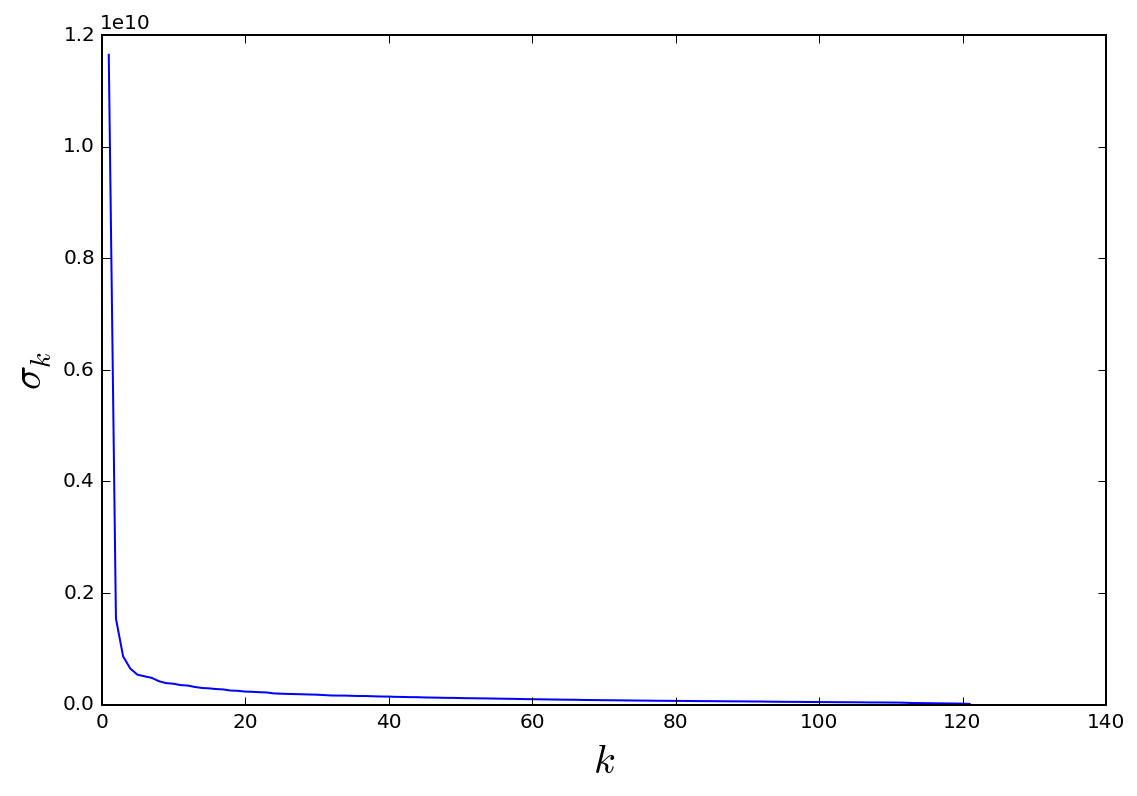

In [4]:
u,s,vt = np.linalg.svd(Atraf)
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,1+len(s)),s)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)

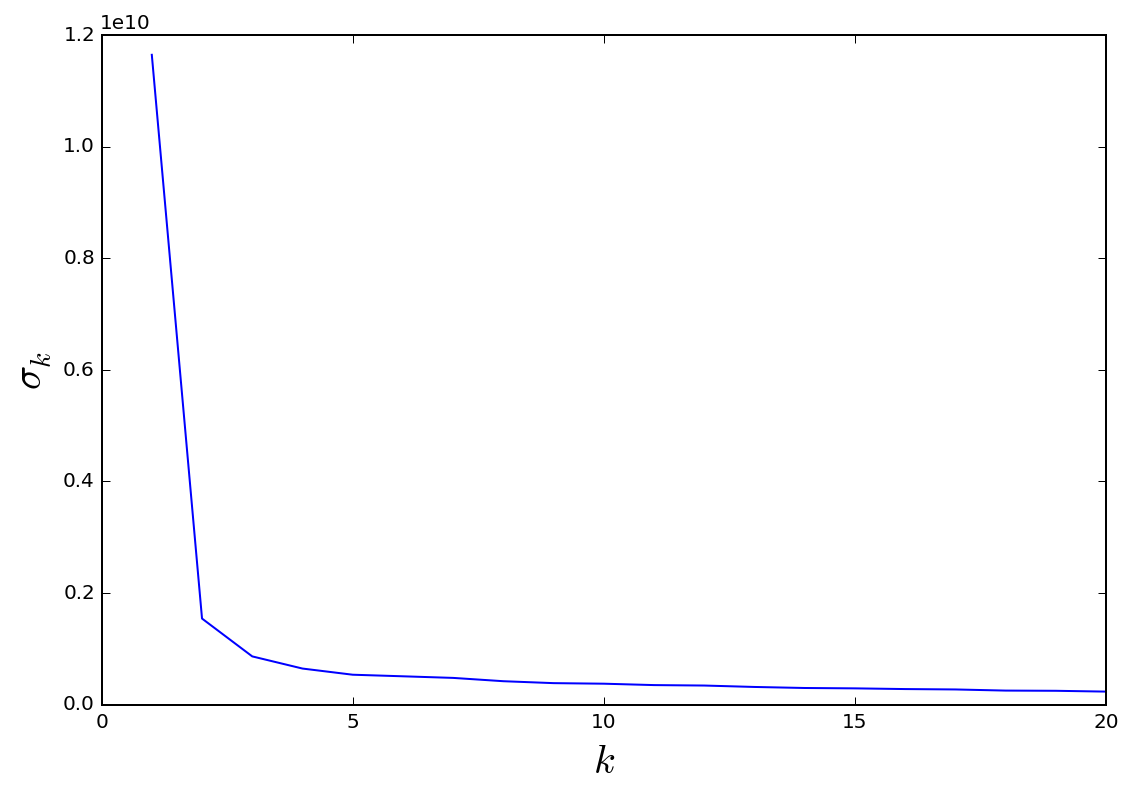

In [5]:
fig = plt.figure(figsize=(9,6))
Anorm = np.linalg.norm(Atraf)
plt.plot(range(1,21),s[0:20])
plt.xlim([0,20])
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)

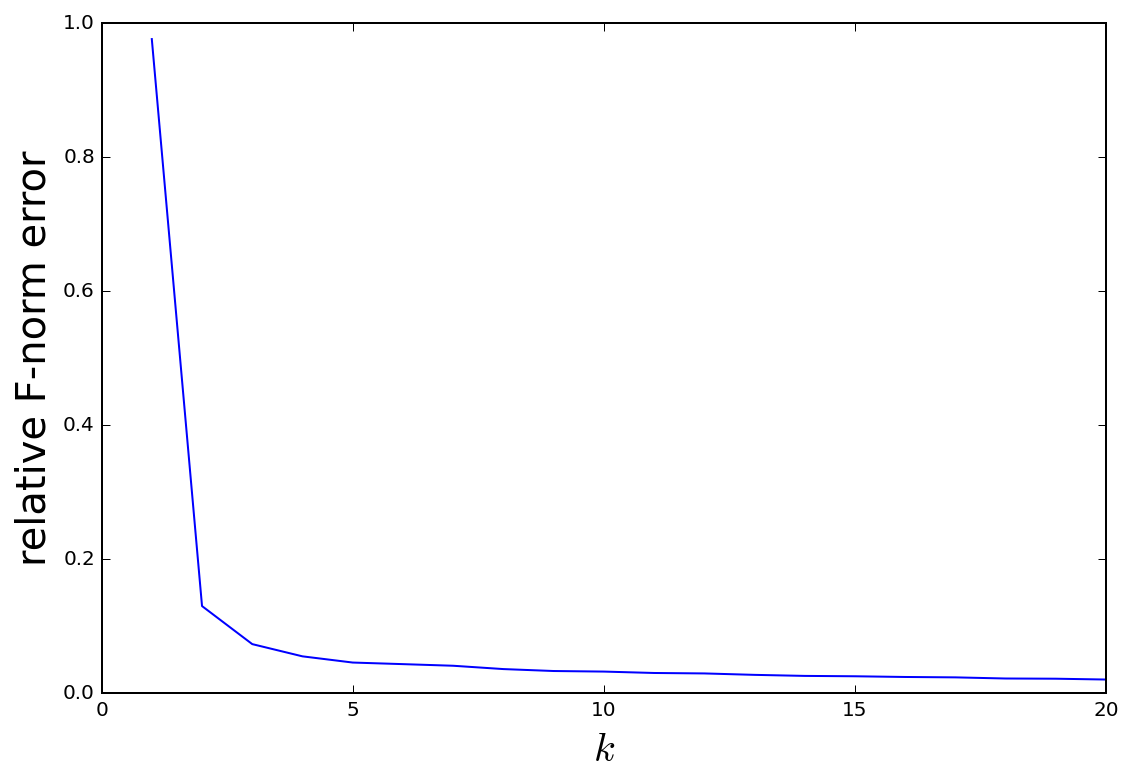

In [6]:
fig = plt.figure(figsize=(9,6))
plt.plot(range(1,21),s[0:20]/Anorm)
plt.xlim([0,20])
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'relative F-norm error',size=20)

In [7]:
s[0:10]/Anorm

array([ 0.97599686,  0.12922614,  0.07240894,  0.05414364,  0.04488242,
        0.04251024,  0.0401026 ,  0.03513407,  0.0322399 ,  0.03139553])

So we are down to 4% relative error using only the 7 vectors $\{\vu_1,\dots,\vu_7\}$ to describe all the columns of $A$.

Let's look at some other examples:

#### Source-Destination Traffic Matrices.

Here, the matrix is the number of bytes from each source to each destination in a major ISP over one hour.

<center>
<img width=375, src = images/src-dest-ISP.png/>
</center>

This is a plot of the normalized singular values.

Note that Origin-Destination flows are often modeled using a so-called "gravity model."  

In this model, the traffic $f_{ij}$ that enters the network at $i$ and leaves the network at $j$ is modeled as

$$f_{ij} = \alpha_i \beta_j$$

Seen from our standpoint, this is simply a rank-1 model. Every column $f_{*j}$ is a multiple of the single vector $\alpha.$

#### Likes on Facebook.

Here, the matrices are 

1. Number of likes:  Timebins $\times$ Users
2. Number of likes:  Users $\times$ Page Categories
3. Entropy of likes across categories:  Timebins $\times$ Users

<center>
<img width=650, src = images/facebook.png/>
</center>


#### Social Media Activity.

Here, the matrices are 

1. Number of Yelp reviews:  Timebins $\times$ Users
2. Number of Yelp reviews:  Users $\times$ Yelp Categories
3. Number of Tweets:  Users $\times$ Topic Categories

<center>
<img width=650, src = images/yelp-twitter.png/>
</center>


#### User preferences over items.

Example: the Netflix prize worked with partially-observed matrices like this:

$$\left[\begin{array}{ccccccc}
  ~&~&~&\vdots&~&~&~\\
  &~&3&2&~&1&\\
  &1&~&1&~&~&\\
  \dots&~&2&~&4&~&\dots\\
  &5&5&~&4&~&\\
  &1&~&~&1&5&\\
  ~&~&~&\vdots&~&~&~\\
\end{array}
\right]
$$

Where the rows correspond to users, the columns to movies, and the entries are ratings.

Although the problem matrix was of size 500,000 $\times$ 18,000, the winning approach modeled the matrix as having __rank 20 to 40.__

#### Images.

This is not network measurement data, but good to understand nonetheless:

Image data is often low-dimensional.

For example, here is an original photo:

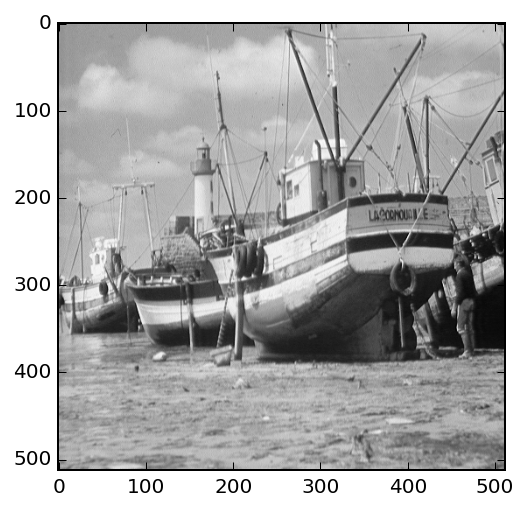

In [8]:
boat = np.loadtxt('data/images/boat/boat.dat')
import matplotlib.cm as cm
plt.figure()
plt.imshow(boat,cmap = cm.Greys_r)

Let's look at its spectrum:

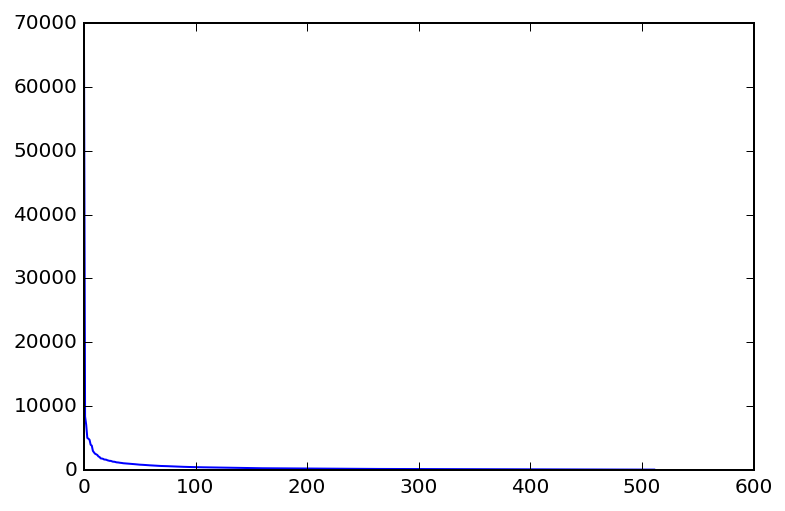

In [9]:
u,s,vt=np.linalg.svd(boat,full_matrices=False)
plt.figure()
plt.plot(s)

This matrix has rank of 512.   But its effective rank is low, perhaps 40.

Let's find the closest rank-40 matrix and view it.

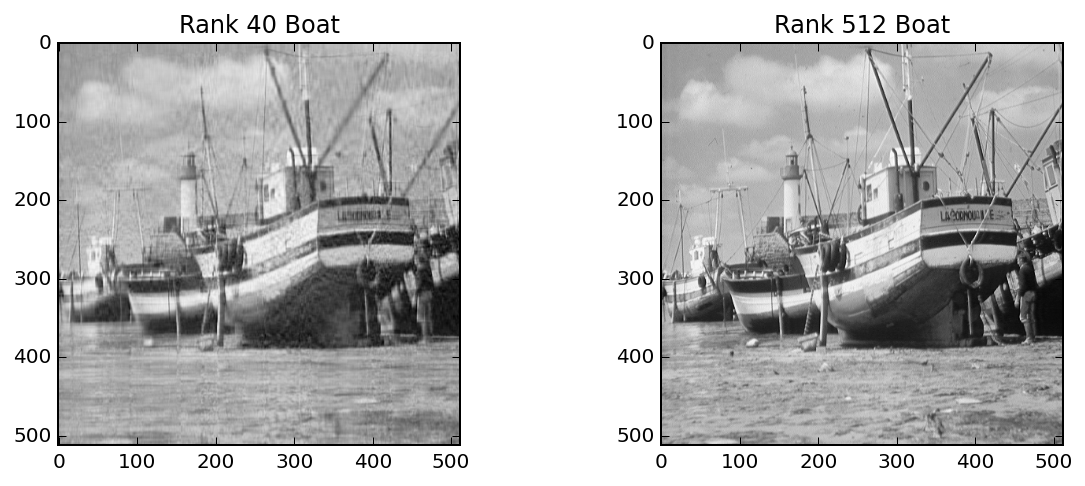

In [10]:
# construct a rank-40 version of the boat
scopy = s.copy()
scopy[40:]=0
boatApprox = u.dot(np.diag(scopy)).dot(vt)
#
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.imshow(boatApprox,cmap = cm.Greys_r)
plt.title('Rank 40 Boat')
plt.subplot(1,2,2)
plt.imshow(boat,cmap = cm.Greys_r)
plt.title('Rank 512 Boat')
plt.subplots_adjust(wspace=0.5)

## Interpretations of the Low-Dimensional Phenomenon

How can we understand this low-dimensional phenomenon in general?

There are two helpful interpretations:

1. Common Patterns
2. Latent Factors

__Common Patterns.__

$$ A \approx U'\Sigma'(V')^T $$

In this interpretation, we think of each column of $A$ as a combination of the columns of $U'$.

Let's use as our example $\va_1,$ the first column of $A$

The equation above tells us that

$$\va_1 \approx v_{11}\sigma_1\vu_1 + v_{12}\sigma_2\vu_2 + \dots + v_{1k}\sigma_k\vu_k.$$

In other words, $\vu_1$ (the first column of $U$) is the "strongest" pattern occurring in $A$, and its strength is measured by $\sigma_1$.

Here is an view of the first few columns of $U\Sigma$ for the traffic matrix data:

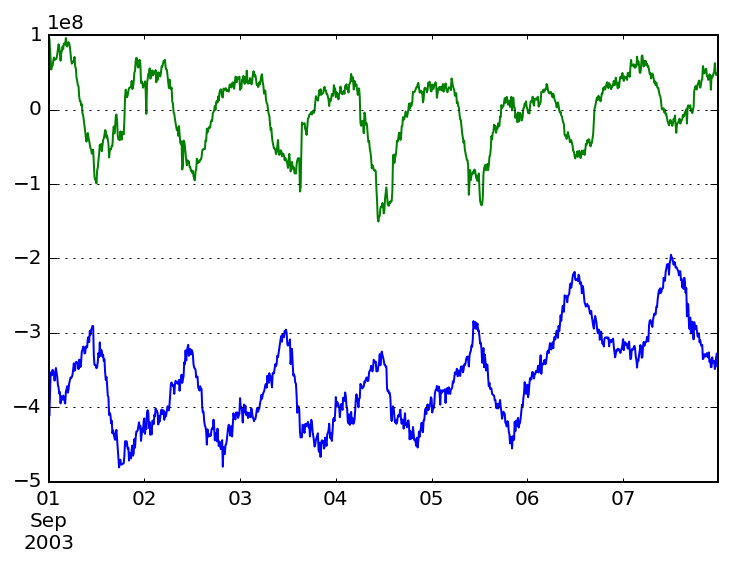

In [11]:
u,s,vt = np.linalg.svd(Atraf,full_matrices=False)
uframe = pd.DataFrame(u.dot(np.diag(s)),index=pd.date_range('9/1/2003',freq='10min',periods=1008))
uframe[0].plot()
uframe[1].plot()

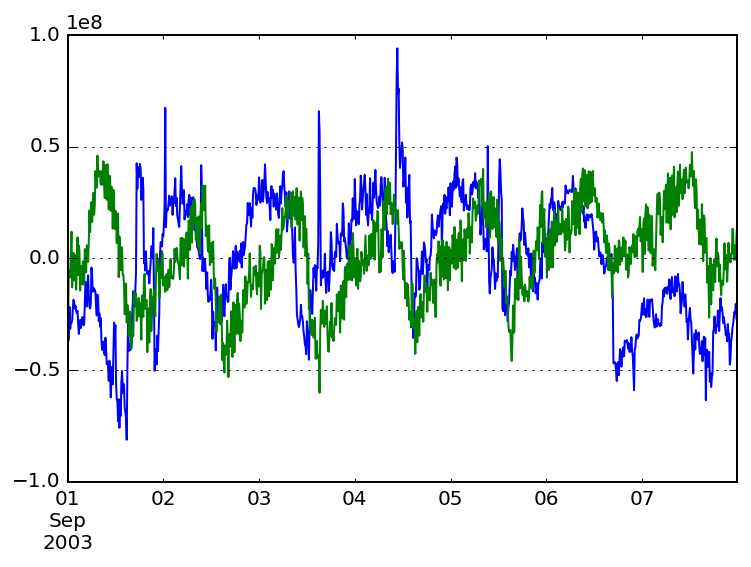

In [12]:
uframe[2].plot()
uframe[3].plot()

__Latent Factors.__

$$ A \approx U'\Sigma'(V')^T $$

In this interpretation, we think of each element of $A$ as the inner product of a row of $U'\Sigma'$ and a row of $V'$.

Let's say we are working with a matrix of users and items, say movies as in the Netflix prize.

Recall the structure from a previous slide:

$$ \mbox{users}\left\{\begin{array}{c}\;\\\;\\\;\\\;\\\;\end{array}\right.\;\;\overbrace{\left[\begin{array}{cccc}\begin{array}{c}\vdots\\\vdots\\{\bf a_1}\\\vdots\\\vdots\end{array}&\begin{array}{c}\vdots\\\vdots\\{\bf a_2}\\\vdots\\\vdots\end{array}&\dots&\begin{array}{c}\vdots\\\vdots\\{\bf a_n}\\\vdots\\\vdots\end{array}\\\end{array}\right]}^{\mbox{movies}} =
\overbrace{\left[\begin{array}{cc}\vdots&\vdots\\\vdots&\vdots\\\sigma_1\vu_1&\sigma_k\vu_k\\\vdots&\vdots\\\vdots&\vdots\end{array}\right]}^{\large k}
\times
\left[\begin{array}{ccccc}\dots&\dots&\vv_1&\dots&\dots\\\dots&\dots&\vv_k&\dots&\dots\end{array}\right]$$

Then the rating that a user gives a move is the inner product of a $k$ element vector that corresponds to the user, and a $k$ element vector that corresponds to the movie.

We can therefore think of each user's preferences as being captured by point in $\R^k$.  This is a __latent factor.__

The remarkable thing is that a person's preferences for all 18,000 movies can be captured in a 20-element vector!

<center>
<img width=650, src = images/Movie-Latent-Space.png/>
</center>
Source: Koren et al, IEEE Computer, 2009 


<center>
<img width=650, src = images/Netflix-Latent-Factors.png/>
</center>
Source: Koren et al, IEEE Computer, 2009 

# Why Does the Low-Dimensional Phenomenon Matter?

We'll discuss two ways to exploit the low-dimensional phenomenon:

1. Anomaly Detection
2. Matrix Completion

## Anomaly Detection via the Low-Dimensional Phenomenon

The first application of the phenomenon is anomaly detection.

The anomaly detection problem is as follows: given a population $P$, divide the members of $P$ in a normal set $N$ and an anomalous set $O$.

The most common way to address this problem is to construct a distributional model for $N$ and identify the set $O$ as those that have low probability under this model.   More generally, one may try to use machine learning to build a classifier that separates $N$ and $O$.

The difficulty with these approaches is that they require labeled training data -- some ground truth separation of normal and anomalous items must be known in advance.

Instead, if the low-dimensional phenomenon holds, we can do a good job of anomaly detection __without__ any labeled data.

We make the assumption that in the dataset $P$, __the majority of data or users are normal.__

Then we can use the low-dimensional phenomenon to separate abnormal data from the population of normal data.

If $N$ is a set of users, this can be effective for cybersecurity, separating benign from misbehaving users.

In practice, given a set of measurements:

* Assume that “most” observations are normal
* Build a low-dimensional (linear) model for them
* What is not well predicted is anomalous and most likely some form of misbehavior


In practice, this is a simple process.

Given a data matrix $A$:

1.  Compute the Singular value decomposition of $A$, $$U\Sigma V^T = A.$$
2.  Compute a low-rank approximation to $A$, $$N = U'\Sigma'(V')^T.$$
3.  Compute the data not explained by $N$:  $$O = A-N.$$
4.  Indentify the rows of $O$ with largest $\ell_2$ norm: these rows correspond to anomalies.

There are two unspecified steps in the process:

1. Selecting the columns of $U$ to be used in forming $N$
2. Deciding how many of the largest rows of $O$ are anomalies.

For 1, the general idea is to choose a $k$ at the knee of the singular value plot.  
For 2, there are statistical methods that generally work reasonably well.

### Example 1: Traffic OD Flows

This data consists of the number of bytes flowing between 121 origin-destination pairs in the Abilene network, sampled at 10 minute intervals, for one week.

Rows are timebins, Columns are source-destination pairs.

First we will look at the columns of $U$.

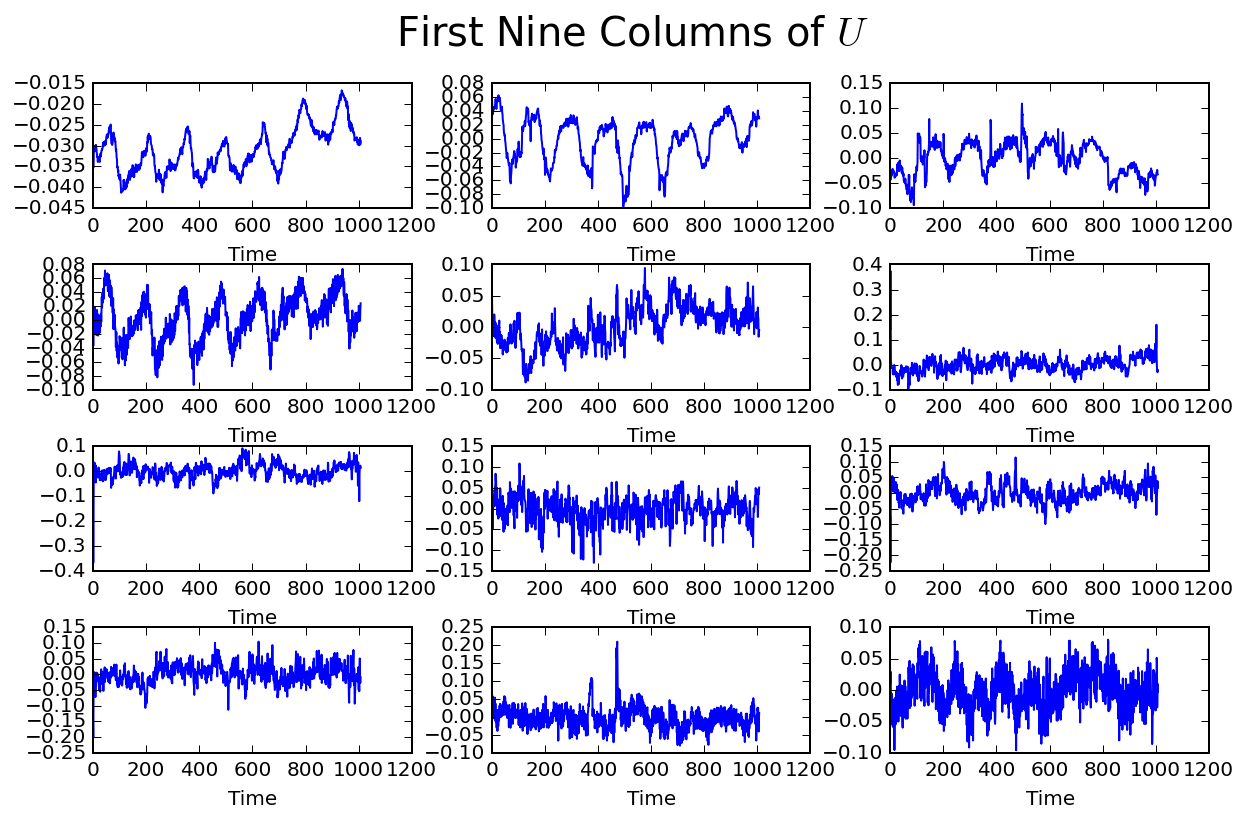

In [13]:
u,s,vt = np.linalg.svd(Atraf,full_matrices=False)
plt.figure(figsize=(10,6))
for i in range(1,13):
    ax = plt.subplot(4,3,i)
    plt.plot(u[:,i-1])
    plt.xlabel('Time')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('First Nine Columns of $U$',size=20)

Next we will extract the anomalous traffic and look at its volume at each time point.

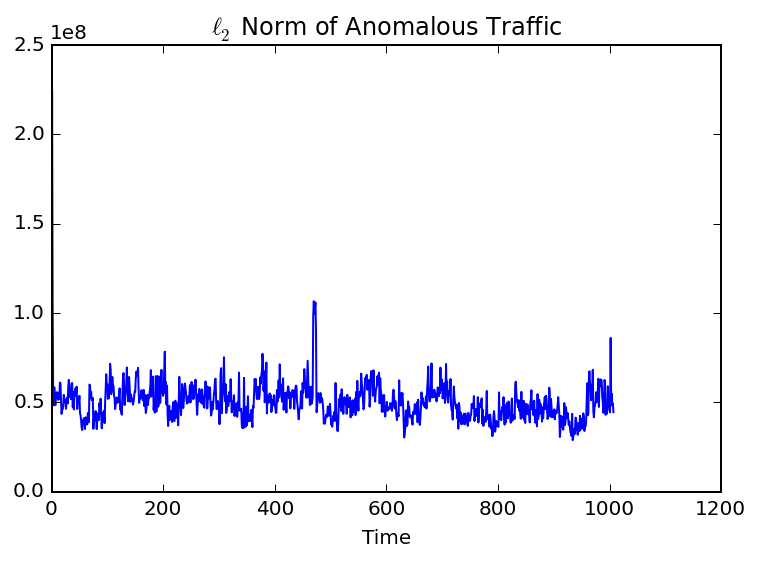

In [14]:
unorm = u[:,0:6]
P = unorm.dot(unorm.T)
Ntraf = P.dot(Atraf)
Otraf = Atraf - Ntraf
Onorm = np.linalg.norm(Otraf,axis=1)
plt.plot(Onorm)
plt.xlabel('Time')
plt.title(r'$\ell_2$ Norm of Anomalous Traffic')

Now we'll choose the top 15 anomalous time points and look at where they fall.

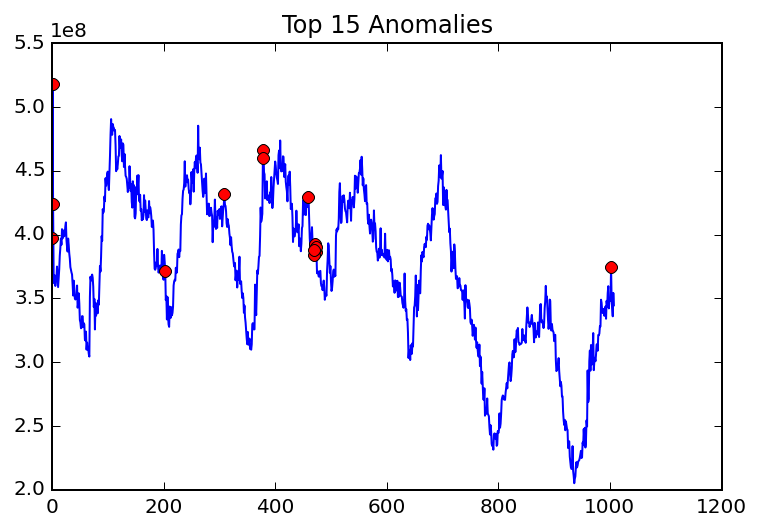

In [15]:
# choose the top 15 anomalies
anomalies = np.argsort(Onorm)[-15:]
# plot the traffic norm at those points
Anorm = np.linalg.norm(Atraf,axis=1)
plt.plot(Anorm)
plt.plot(anomalies,Anorm[anomalies],'ro')
plt.title('Top 15 Anomalies')

### Example 2: Facebook Spatial Likes

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, across the 210 content categories that Facebook assigns to pages.

Rows are users, Columns are categories.

First we'll look at the total number of likes for each user (the row sums).

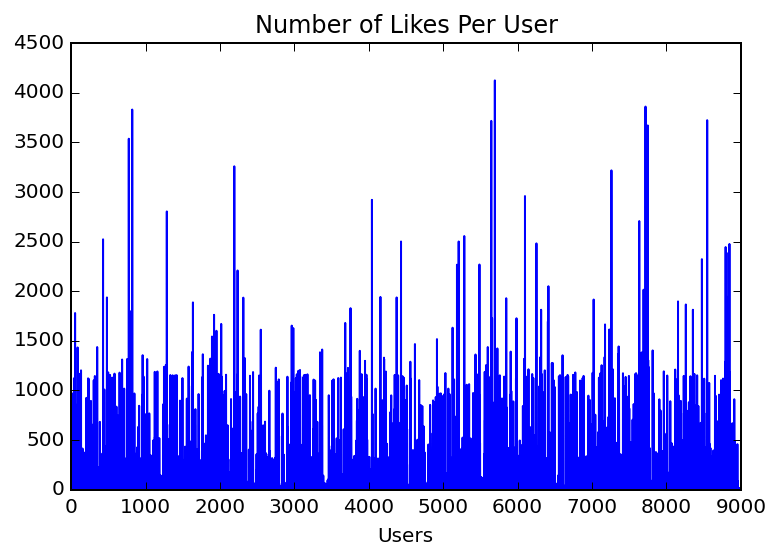

In [16]:
data = np.loadtxt('data/social/data/spatial_data.txt')
FBSpatial = data[:,1:]
FBSnorm = np.linalg.norm(FBSpatial,axis=1,ord=1)
plt.plot(FBSnorm)
plt.title('Number of Likes Per User')
plt.xlabel('Users')

Now let's check whether the low dimensional phenomenon holds.

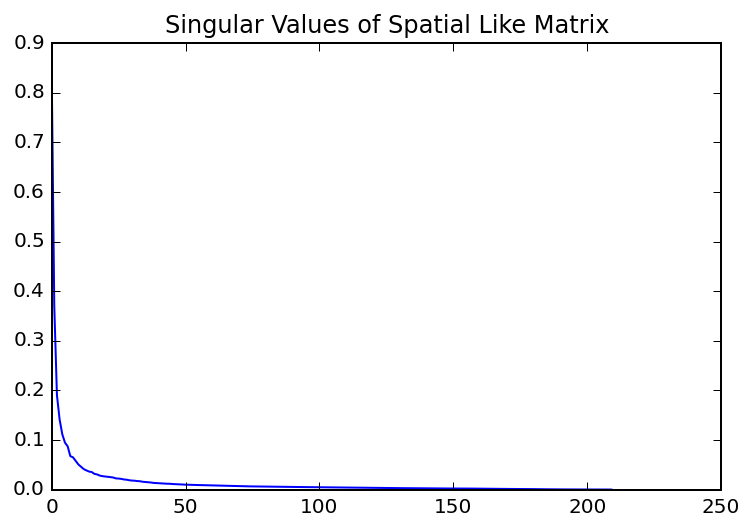

In [17]:
u,s,vt = np.linalg.svd(FBSpatial,full_matrices=False)
plt.plot(s/np.linalg.norm(FBSpatial))
plt.title('Singular Values of Spatial Like Matrix')

Now let's 

1. Separate the portion of the data lying in the normal space from the amonalous space,
2. Identify the top 30 anomalous users (having the largest anomalous component), and
3. Plot their total number of likes against the set of all users.

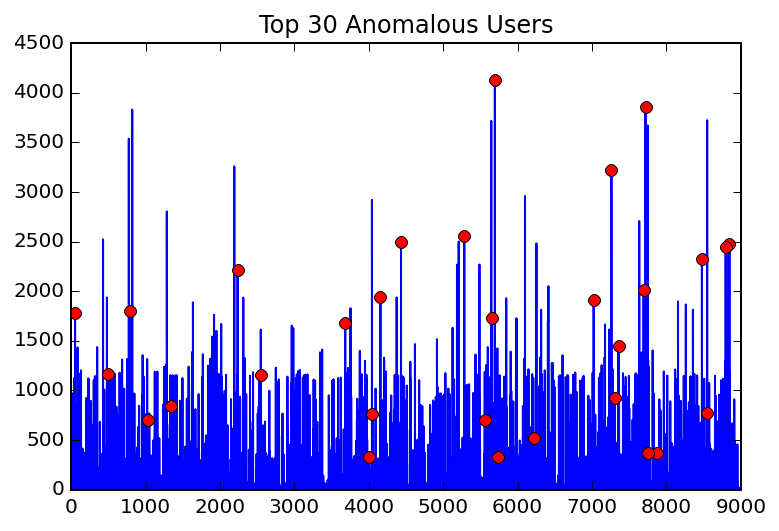

In [18]:
unorm = u[:,0:25]
P = unorm.dot(unorm.T)
N = P.dot(FBSpatial)
O = FBSpatial - N
Onorm = np.linalg.norm(O,axis=1)
# large = np.nonzero(Onorm>100))
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(FBSnorm)
plt.plot(anomSet,FBSnorm[anomSet],'ro')
plt.title('Top 30 Anomalous Users')

Next we'll pick out nine anomalous users and look at their pattern of likes across the 210 categories.

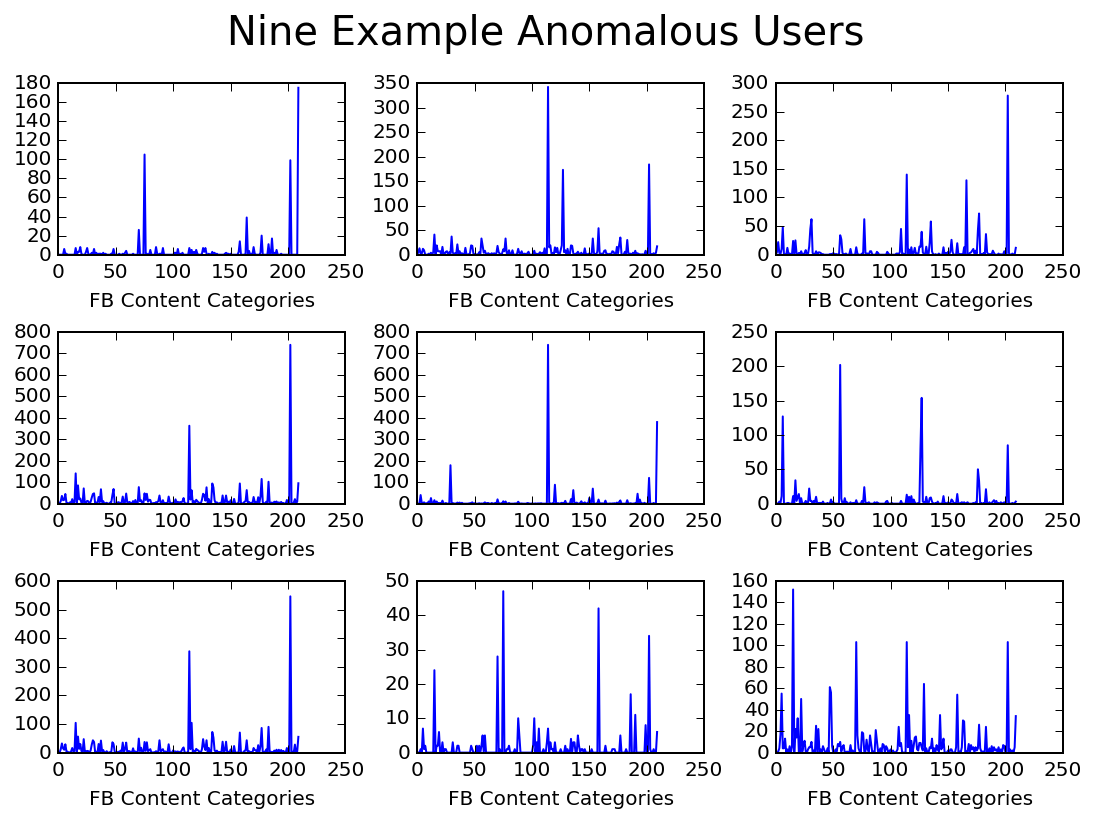

In [19]:
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[anomSet[i-1],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Users',size=20)

And let's do the same for nine normal users.

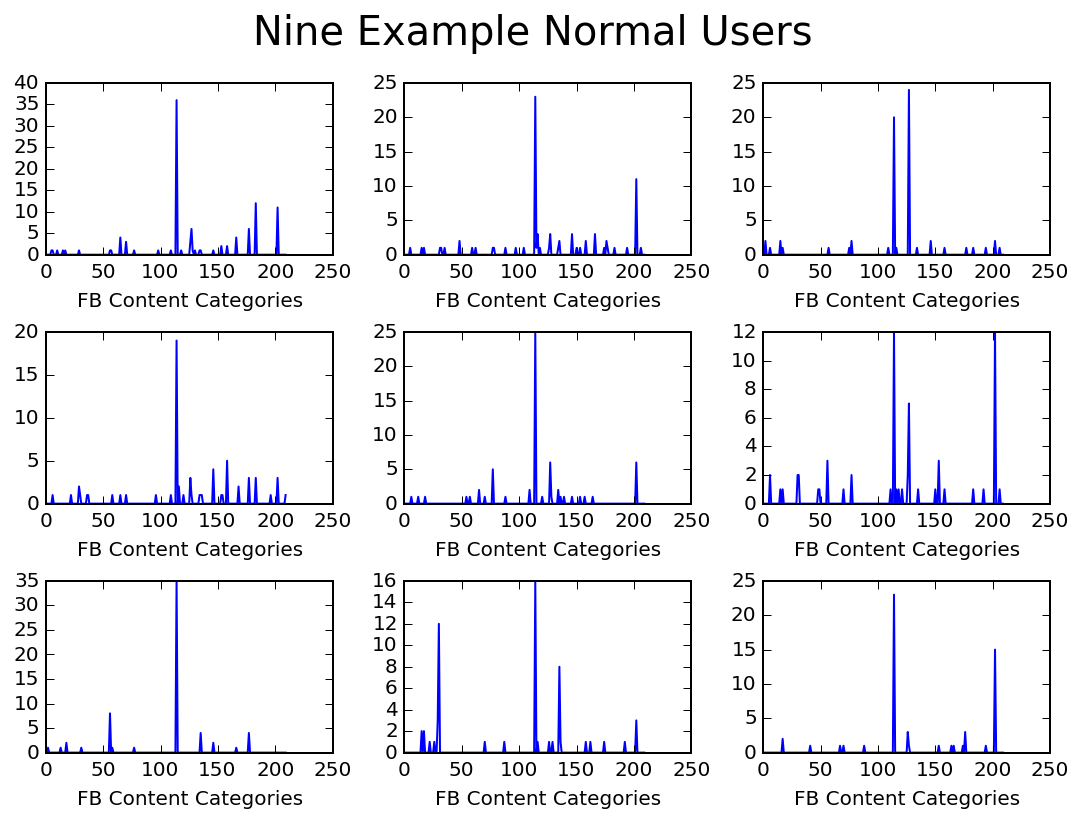

In [20]:
# choose non-anomalous users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBSnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[set[max[i-1]],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Users',size=20)

### Example 3: Facebook Temporal LIkes

This data consists of the number of 'Likes' for each of 9000 users, over 6 months, on a daily basis

Rows are users, Columns are days.

First we'll look at the singular values.

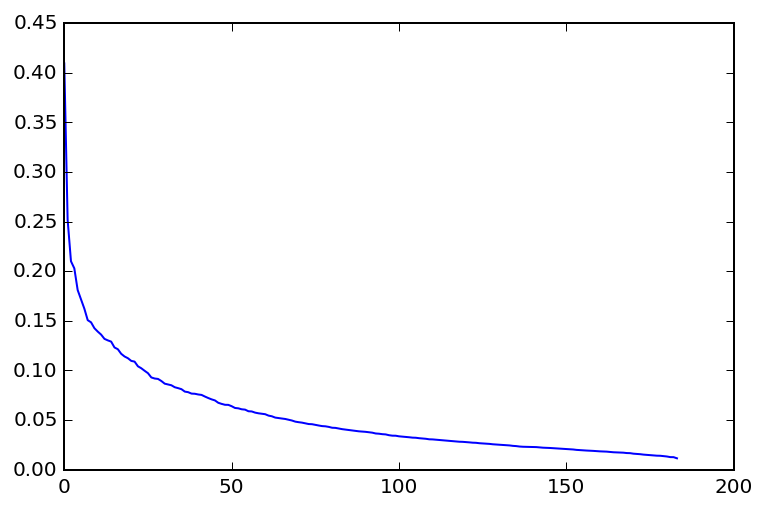

In [21]:
data = np.loadtxt('data/social/data/temporal_data.txt')
FBTemporal = data[:,1:]
FBTnorm = np.linalg.norm(FBTemporal,axis=1,ord=1)
u,s,vt = np.linalg.svd(FBTemporal,full_matrices=False)
plt.plot(s/np.linalg.norm(FBTemporal))

Next, plot the anomalous users as before.

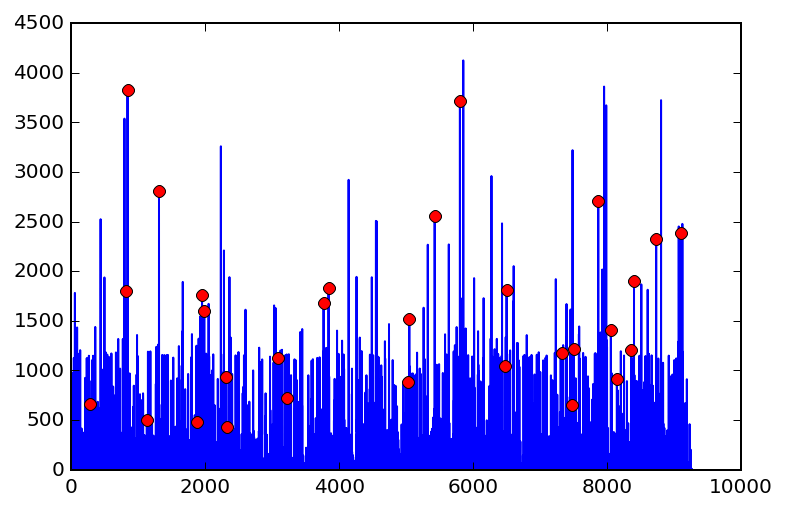

In [22]:
# choose the top 25 columns of U for the normal space
unorm = u[:,0:24]
P = unorm.dot(unorm.T)
N = P.dot(FBTemporal)
O = FBTemporal - N
Onorm = np.linalg.norm(O,axis=1)
# get top 30 anomalies
anomSet = np.argsort(Onorm)[-30:]
plt.plot(FBTnorm)
plt.plot(anomSet,FBTnorm[anomSet],'ro')

Now let's look at sample anomalous and normal users.   

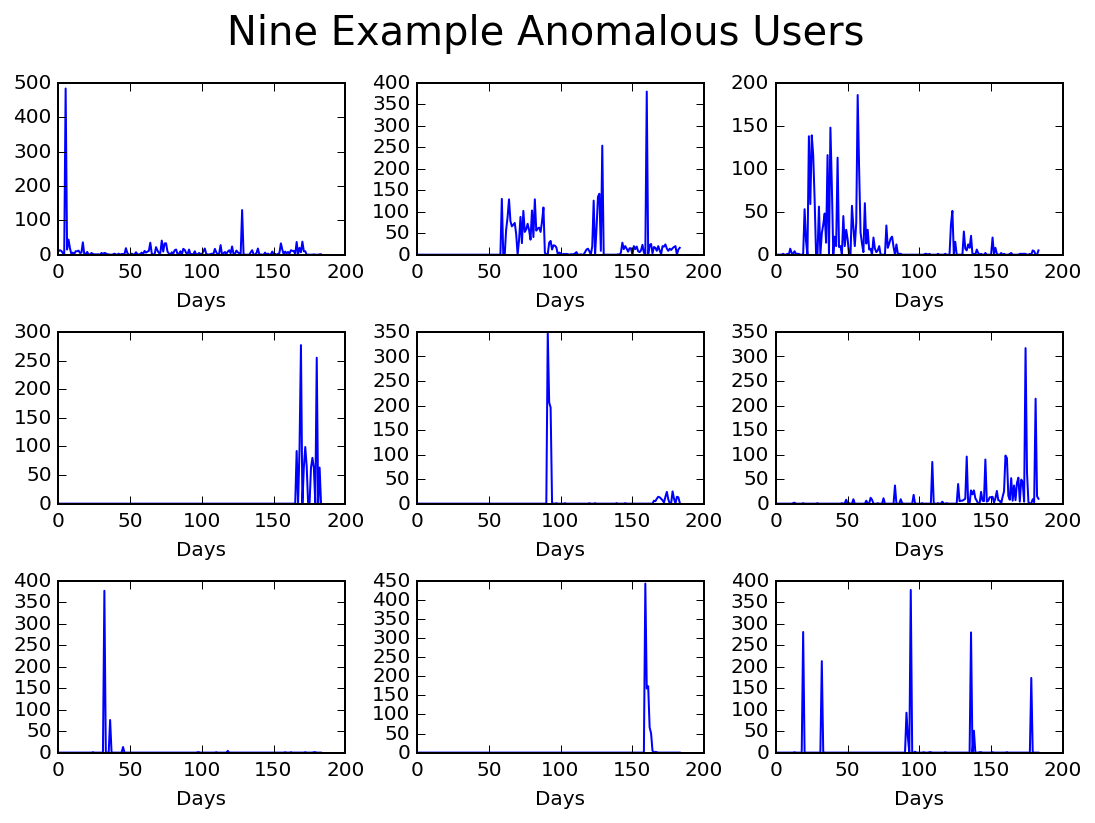

In [23]:
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBTemporal[anomSet[i-1],:])
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Anomalous Users',size=20)

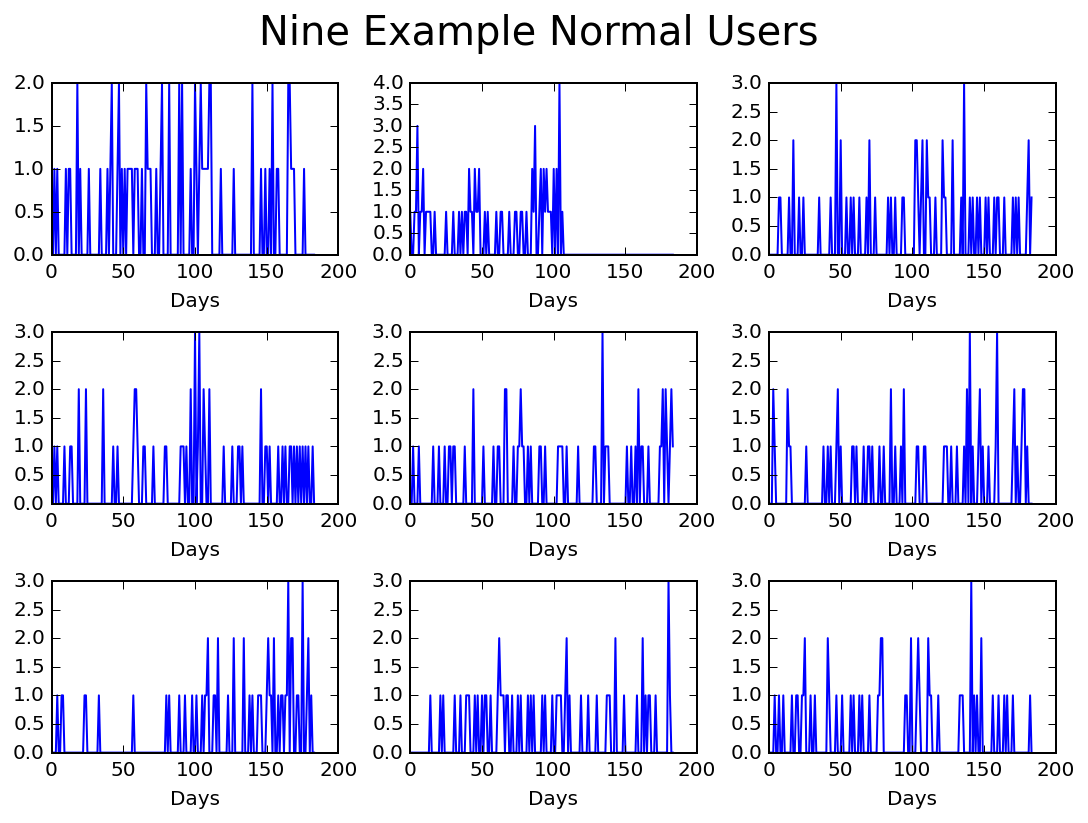

In [24]:
# choose non-anomalous users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBTnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBTemporal[set[max[i-1]],:])
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example Normal Users',size=20)

Interestingly, what makes a user anomalous seems to have reversed from the case of the spatial data.

## Matrix Completion via the Low Dimensional Phenomenon

The second set of analyses we will look at concern __inferring missing data.__

In many situations data is missing or only partially available.

For example, in network measurements, data may be missing due to 

* equipment failure
* lack of visibility
* partial measurement

When dealing with data that reflects human activity, the low rank phenomenon can lend a helping hand.

Recall that the low rank phenomenon means that the $m\times n$ matrix $A$ is actually only determined by $km + kn$ values.

This means if we can observe enough values (intuitively, some multiple of $k(n+m)$) we may be able to recover the missing values.

Consider the netflix problem:  the number of entries in the (complete) $A$ is 500,000 $\times$ 18,000.  However, if we can model $A$ as having rank $k = 40$, then it may be possible to reconstruct the entire matrix from only $k(m+n)/mn =$ 0.1% of its entries.

Given an arbitrary matrix, observing a subset of its entries provides no knowledge of the missing entries.  __But__ if the matrix is __low-rank__ then there is hope.

In recent years many approaches have arisen for estimating the missing entries of a low-rank matrix.  These approaches fall under the general heading of __matrix completion.__

The various methods for performing matrix completion are outside our scope, but we can sketch one general strategy.

Consider a matrix $A$ for which we are given only a subset $\Omega$ of entries.   Further, we assume that we know that $A$ is well approximated by a rank $k$ matrix.

Then as we've seen, we can express $A$ as 
   $$A = UV^T.$$
   
Let us denote the known entries in $A$ as $A_\Omega$.

If we were to start with arbitrary estimates of $U$ and $V$, we could successively improve them by computing:

$$U' = \min_{B}\Vert A_\Omega-BV^T\Vert$$

and 

$$V' = \min_{C}\Vert A_\Omega-U'C^T\Vert$$

Where the minimization is performed only over the known elements $\Omega.$ Then setting $U \leftarrow U'$ and $V \leftarrow V'$ we can iterate.

Note that each of the two minimizations above is a least-squares problem that can be solved quickly.

This is the approach taken by `lmafit()` which is the code we will use.

In [25]:
from lmafit import lmafit_mc_adp as lmft

Let's see how well this works on network traffic data.

We can start with our Abilene traffic data `Atraf` and hide most entries, then reconstruct what was missing.

In [33]:
A = Atraf.values
shape = np.shape(A)
avgrms = []
testvals = [x/100.0 for x in range(10)] + [x/10.0 for x in range(1,10)]
for p in testvals:
    rmsvals = []
    for i in range(10):
        mask = (np.random.random_sample(shape) < p)
        Known = np.nonzero(mask)
        dat = A[Known]
        U,VT,Out = lmft(shape[0],shape[1],1,Known,dat,0)
        Est = U.dot(VT)
        rmsvals.append(np.linalg.norm(Atraf-Est)/np.linalg.norm(Atraf))
    avgrms.append(np.mean(np.array(rmsvals)))

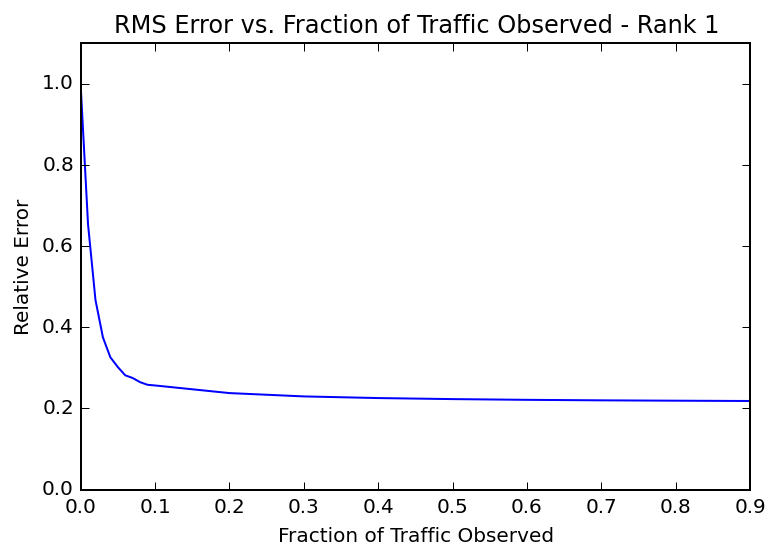

In [35]:
plt.plot(testvals,avgrms,'-')
plt.title('RMS Error vs. Fraction of Traffic Observed - Rank 1')
plt.xlabel('Fraction of Traffic Observed')
plt.ylabel('Relative Error')
plt.ylim(ymin=0)
print ''

Let us see this in terms of individual flows:

In [67]:
Ests = []
p = 0.05
for i in range(10):
    mask = (np.random.random_sample(shape) < p)
    Known = np.nonzero(mask)
    dat = A[Known]
    U,VT,Out = lmft(shape[0],shape[1],1,Known,dat,0)
    Est = U.dot(VT)
    Ests.append(Est)
Est = np.mean(Ests,axis=0)

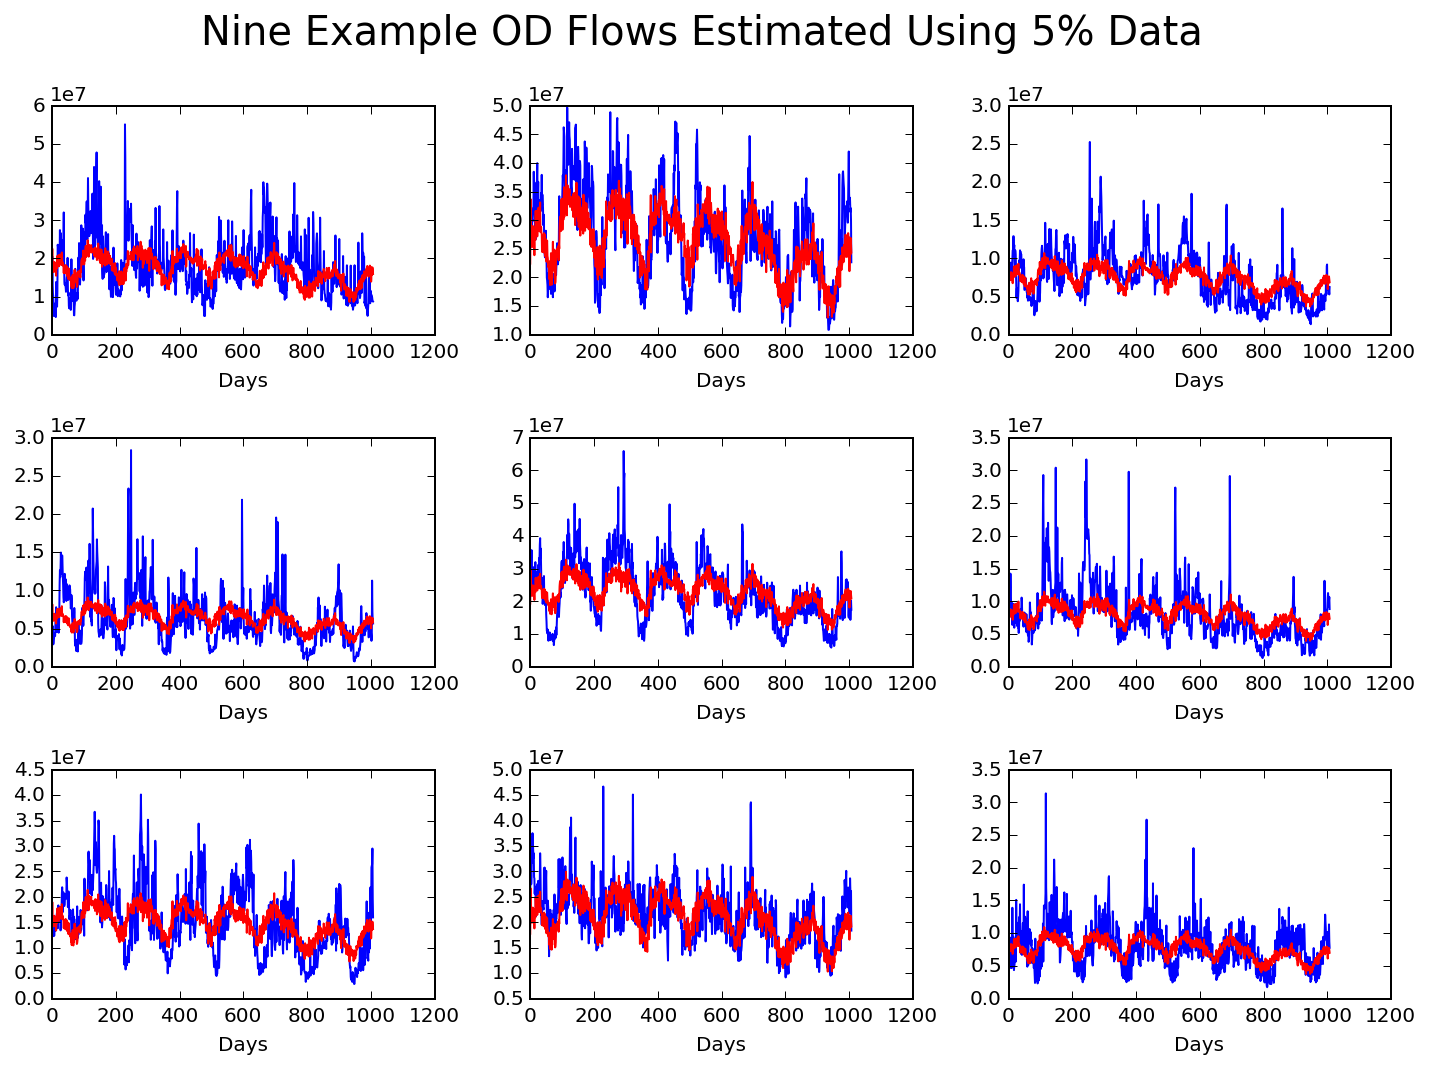

In [68]:
plt.figure(figsize=(12,8))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(A[:,i-1])
    plt.plot(Est[:,i-1],'r-')    
    plt.xlabel('Days')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
plt.suptitle('Nine Example OD Flows Estimated Using 5% Data',size=20)

Finally, let's take a look at how this performs on image reconstruction:

In [106]:
p = 0.30
boatPartial = boat.copy()
shape = np.shape(boat)
mask = (np.random.random_sample(shape) < p)
boatPartial[~mask] = 0.0
Known = np.nonzero(mask)
dat = boat[Known]
U,VT,Out = lmft(shape[0],shape[1],20,Known,dat,0)
Est = U.dot(VT)

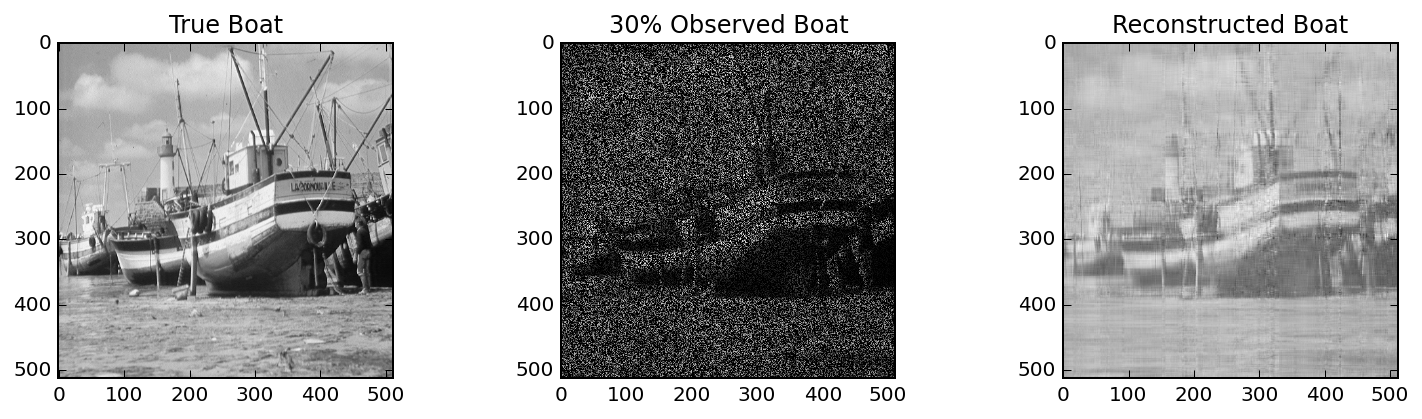

In [107]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(boat,cmap = cm.Greys_r)
plt.title('True Boat')
plt.subplot(1,3,2)
plt.imshow(boatPartial,cmap = cm.Greys_r)
plt.title('30% Observed Boat')
plt.subplot(1,3,3)
plt.imshow(Est,cmap = cm.Greys_r)
plt.title('Reconstructed Boat')
plt.subplots_adjust(wspace=0.5)